In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
from sklearn.metrics import confusion_matrix

In [2]:
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

CUDA Available: True
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [ ]:
SAVE_PATH ='./Data/dataset_classification/'

X = np.load(f'{SAVE_PATH}X.npy')
Z = np.load(f'{SAVE_PATH}Z.npy')
print(type(X[0]))
print(type(Z[0]))

<class 'numpy.ndarray'>
<class 'numpy.str_'>


In [9]:
print(f"Type of Z: {type(Z)}, dtype of Z: {Z.dtype}")
print(f"First 5 labels: {Z[:5]}")

Type of Z: <class 'numpy.ndarray'>, dtype of Z: <U9
First 5 labels: ['banh-cuon' 'banh-cuon' 'banh-cuon' 'banh-cuon' 'banh-cuon']


In [10]:
# Mã hóa nhãn
label_encoder = LabelEncoder()
Z_encoded = label_encoder.fit_transform(Z)

In [11]:
print(f"X shape: {X.shape}")  # (số lượng ảnh, chiều cao, chiều rộng, số kênh)
print(f"Z shape: {Z.shape}")  # (số lượng ảnh,)
print(f"Example label: {Z[0]}")  # Xem thử nhãn

X shape: (3420, 224, 224, 3)
Z shape: (3420,)
Example label: banh-cuon


In [12]:
print(np.unique(Z))

['banh-cuon' 'banh-mi' 'bun-bo' 'bun-dau' 'com-tam']


In [13]:
# Biến đổi dữ liệu cho tập train (tăng cường dữ liệu)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Lật ngang ảnh với xác suất 50%
    transforms.RandomRotation(degrees=15),  # Xoay ảnh ±15 độ
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Điều chỉnh màu sắc
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Cắt một phần ảnh rồi resize
    transforms.ToTensor(),  # Chuyển thành Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa ảnh
])

# Biến đổi dữ liệu cho tập test (không có data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize ảnh về 224x224
    transforms.ToTensor(),           # Chuyển ảnh thành Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa
])


class CustomDataset(Dataset):
    def __init__(self, X, Z, transform=None):
        self.X = X
        self.Z = Z
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.Z[idx]

        # Đảm bảo image là một NumPy array trước khi chuyển đổi
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)  # Chuyển từ NumPy array sang PIL Image

        if self.transform:
            image = self.transform(image)  # Chuyển đổi thành Tensor

        return image, torch.tensor(label, dtype=torch.long)  # Đảm bảo label là Tensor

# Chia dữ liệu thành train (80%) và test (20%)
X_train, X_test, Z_train, Z_test = train_test_split(X, Z_encoded, test_size=0.2, random_state=42)

# Tiếp tục chia tập train thành train (80%) và validation (20%)
X_train, X_val, Z_train, Z_val = train_test_split(X_train, Z_train, test_size=0.2, random_state=42)

# Tạo Dataset cho train, val và test
train_dataset = CustomDataset(X_train, Z_train, transform=train_transform)
val_dataset = CustomDataset(X_val, Z_val, transform=test_transform)
test_dataset = CustomDataset(X_test, Z_test, transform=test_transform)

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Không cần shuffle
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Không cần shuffle



In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)
        return out

In [16]:
class ResNet50FeatureExtraction(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet50FeatureExtraction, self).__init__()

        # Tải ResNet50 pre-trained từ ImageNet
        pretrained_model = models.resnet50(pretrained=True)

        # Lấy backbone từ pre-trained model
        self.conv1 = pretrained_model.conv1
        self.bn1 = pretrained_model.bn1
        self.relu = pretrained_model.relu
        self.maxpool = pretrained_model.maxpool
        self.layer1 = pretrained_model.layer1
        self.layer2 = pretrained_model.layer2
        self.layer3 = pretrained_model.layer3
        self.layer4 = pretrained_model.layer4
        self.avgpool = pretrained_model.avgpool

        # Giữ backbone cố định (feature extraction)
        for param in self.parameters():
            param.requires_grad = False

        # Tối ưu: Fully connected [2048 -> 256 -> 128 -> 5], Dropout 0.1 ở tầng cuối
        self.fc = nn.Sequential(
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Dropout(0.1)  # Tối ưu: Giảm Dropout từ 0.2 xuống 0.1
        )

        # Khởi tạo trọng số bằng Xavier cho fully connected
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.fc.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Giả sử Z là danh sách các nhãn, xác định số lớp đầu ra
num_classes = len(set(Z))

model = ResNet50FeatureExtraction(num_classes)
# Đưa mô hình lên GPU
model = model.to(device)

# Hiển thị kiến trúc mô hình
summary(model, (3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [18]:
def train(model, train_loader, val_loader, num_epochs=30, learning_rate=0.00005):  # Tối ưu: lr=0.00005
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    # Tối ưu: Chỉ tối ưu fc, weight_decay=0.0001
    optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate, weight_decay=0.0001)
    # Tối ưu: Dùng CosineAnnealingWarmRestarts thay vì CosineAnnealingLR
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        scheduler.step(epoch)  # Tối ưu: Điều chỉnh lr theo epoch

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Saved best model at epoch {best_epoch} with Val Loss: {best_val_loss:.4f}")

    print("Huấn luyện hoàn tất!")
    return train_losses, val_losses, train_accuracies, val_accuracies, best_epoch, all_preds, all_labels

In [19]:
train_losses, val_losses, train_accuracies, val_accuracies, best_epoch, all_preds, all_labels = train(model, train_loader, val_loader, num_epochs=200)

Epoch [1/200] | Train Loss: 1.3396 | Train Acc: 50.69% | Val Loss: 1.0292 | Val Acc: 68.07%
Saved best model at epoch 1 with Val Loss: 1.0292
Epoch [2/200] | Train Loss: 0.9751 | Train Acc: 69.20% | Val Loss: 0.8211 | Val Acc: 71.72%
Saved best model at epoch 2 with Val Loss: 0.8211
Epoch [3/200] | Train Loss: 0.7555 | Train Acc: 76.87% | Val Loss: 0.6328 | Val Acc: 78.10%
Saved best model at epoch 3 with Val Loss: 0.6328
Epoch [4/200] | Train Loss: 0.6836 | Train Acc: 78.11% | Val Loss: 0.5529 | Val Acc: 81.20%
Saved best model at epoch 4 with Val Loss: 0.5529
Epoch [5/200] | Train Loss: 0.6160 | Train Acc: 79.98% | Val Loss: 0.5137 | Val Acc: 81.75%
Saved best model at epoch 5 with Val Loss: 0.5137
Epoch [6/200] | Train Loss: 0.6045 | Train Acc: 78.66% | Val Loss: 0.4837 | Val Acc: 83.03%
Saved best model at epoch 6 with Val Loss: 0.4837
Epoch [7/200] | Train Loss: 0.5565 | Train Acc: 82.31% | Val Loss: 0.5414 | Val Acc: 80.47%
Epoch [8/200] | Train Loss: 0.5388 | Train Acc: 81.95% |

In [20]:
# Tính toán dự đoán trên tập test để vẽ ma trận nhầm lẫn
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [22]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, best_epoch, all_preds, all_labels, class_names=None):
    epochs = range(1, len(train_losses) + 1)

    # Nếu không có class_names, tạo mặc định dựa trên số lớp
    if class_names is None:
        num_classes = len(set(all_labels))
        class_names = [f"Class {i}" for i in range(num_classes)]

    # Tạo figure với 3 subplot
    plt.figure(figsize=(18, 5))

    # 1. Vẽ Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Vẽ Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # 3. Vẽ Confusion Matrix
    plt.subplot(1, 3, 3)
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()

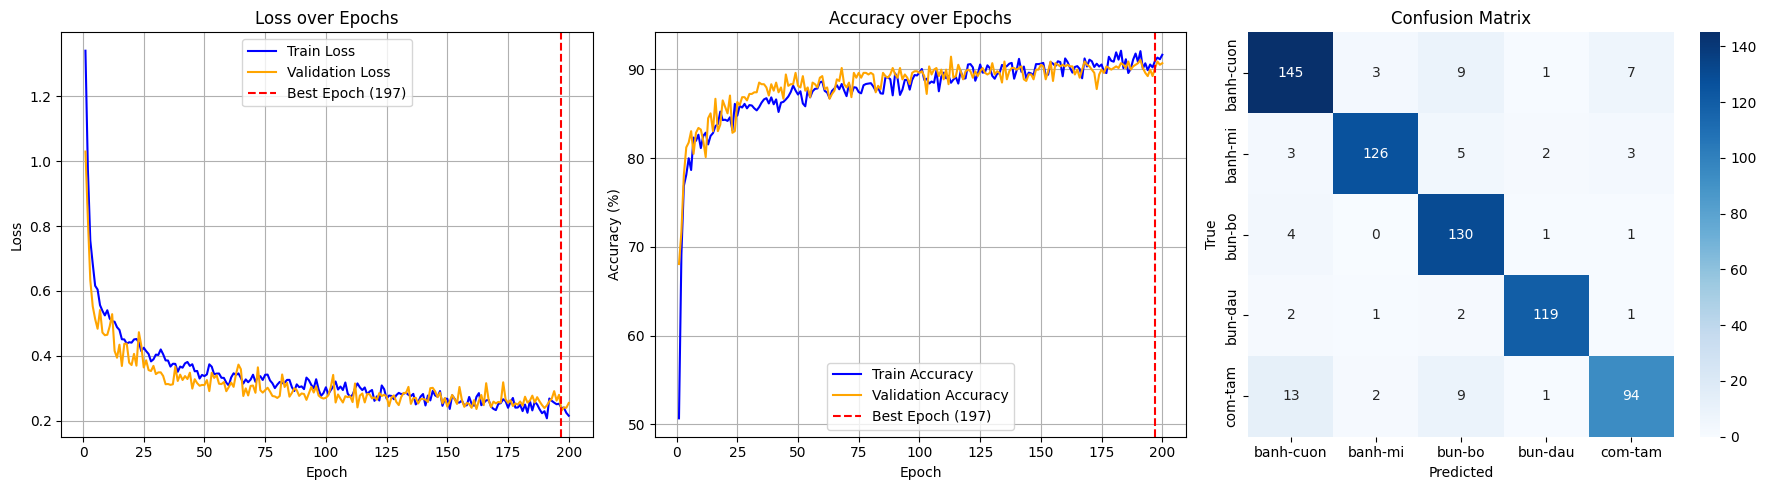

In [23]:
# Vẽ biểu đồ (cung cấp class_names nếu có)
#'banh-cuon' 'banh-mi' 'bun-bo' 'bun-dau' 'com-tam'
class_names = ['banh-cuon', 'banh-mi', 'bun-bo', 'bun-dau', 'com-tam']  # Thay bằng tên lớp thực tế nếu có
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, best_epoch, all_preds, all_labels, class_names)

In [ ]:
def evaluate_and_show_report(model, test_loader, device):
    model.eval()  # Đặt model vào chế độ đánh giá
    y_true, y_pred = [], []

    with torch.no_grad():  # Tắt gradient để tăng tốc độ xử lý
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Lấy lớp có xác suất cao nhất

            y_true.extend(labels.cpu().numpy())  # Chuyển labels về numpy
            y_pred.extend(preds.cpu().numpy())  # Chuyển predictions về numpy

    # Hiển thị classification report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred))

# Gọi hàm để đánh giá model
evaluate_and_show_report(model, test_loader, device)


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       118
           1       0.96      0.95      0.95       111
           2       0.88      0.98      0.93       109
           3       0.92      0.93      0.93       100
           4       0.91      0.85      0.88       110

    accuracy                           0.91       548
   macro avg       0.91      0.91      0.91       548
weighted avg       0.91      0.91      0.91       548

